# ODSC London 22 September - Missing Data Tutorial

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy  as np
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

In most fields, missing data is so common that it is a given. You literally design your studies from the beginning with missing data in mind. The problem is particularly acute for surveys, longitudinal studies, and in clinical medicine.

Overall, handling missing data is so important that (Wainer 2010) considers it one of the “six necessary tools” that researchers need to master in order to successfully tackle problems in their fields in the 21st century.

**Aim of this tutorial**
1. To give you an understanding of missing data and the statistical problems it raises
2. To provide you with a comprehensive, A to Z, applied tutorial on handling missing data


### What is missing data? 

**"Values that are not available and that would be meaningful for analysis if they were observed" (Little 2012)**

When you have missing data for variables that are not of interest in your study, you can consider you do not have missing data. The first step is hence to reduce your dataset to the relevant variables. Then you can start looking at missing data.

In [2]:
# Use Horse Dataset, with 30% missing values
# Description http://archive.ics.uci.edu/ml/datasets/horse+colic
path = "data/horse.csv"
horse_df = pd.read_csv(path, delimiter = ',')

In [3]:
print(len(horse_df))

299


In [4]:
horse_df.head(1)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,...,45.0,8.4,NaN,NaN,died,no,11300,0,0,no


In [5]:
# Can observe already from count that there's 58 values missing for respiratory_rate
horse_df.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,2.990000e+02,239.000000,275.000000,241.000000,53.000000,270.000000,266.000000,101.000000,299.000000,299.000000,299.000000
mean,1.087733e+06,38.168619,72.000000,30.460581,4.707547,46.307407,24.274436,3.039604,3659.709030,90.528428,7.387960
std,1.532032e+06,0.733744,28.646219,17.666102,1.982311,10.436743,27.364194,1.967947,5408.472421,650.637139,127.749768
min,5.184760e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.300000,0.100000,0.000000,0.000000,0.000000
25%,5.289040e+05,37.800000,48.000000,18.000000,3.000000,38.000000,6.500000,2.000000,2111.500000,0.000000,0.000000
50%,5.303010e+05,38.200000,64.000000,25.000000,5.000000,45.000000,7.500000,2.300000,2322.000000,0.000000,0.000000
75%,5.347360e+05,38.500000,88.000000,36.000000,6.500000,52.000000,56.750000,3.900000,3209.000000,0.000000,0.000000
max,5.305629e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,7111.000000,2209.000000


In [6]:
horse_df.pulse.mean()

72.0

In [7]:
horse_df.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp               60
pulse                     24
respiratory_rate          58
temp_of_extremities       56
peripheral_pulse          69
mucous_membrane           47
capillary_refill_time     32
pain                      55
peristalsis               44
abdominal_distention      56
nasogastric_tube         104
nasogastric_reflux       106
nasogastric_reflux_ph    246
rectal_exam_feces        102
abdomen                  118
packed_cell_volume        29
total_protein             33
abdomo_appearance        165
abdomo_protein           198
outcome                    0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
cp_data                    0
dtype: int64

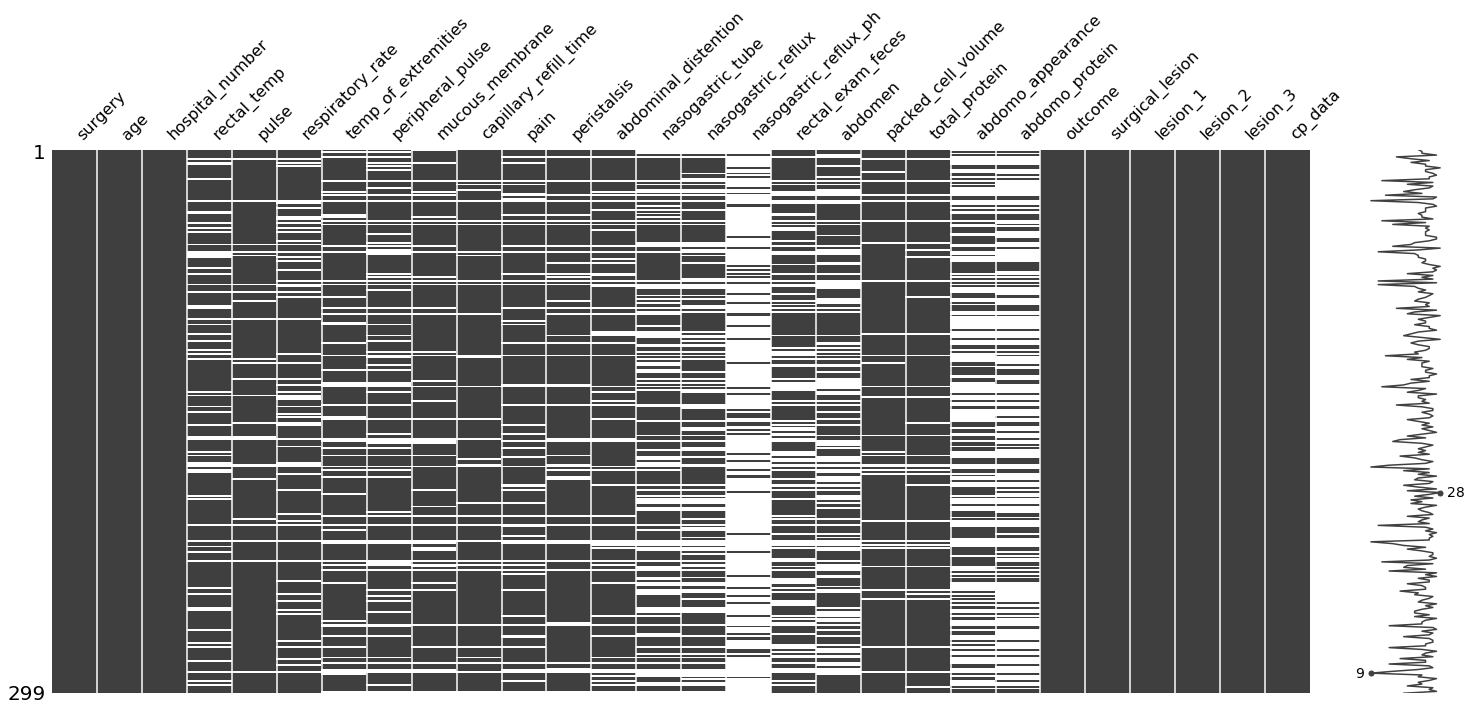

In [8]:
# Use missingno package to visualize missing data
import missingno as msno
msno.matrix(horse_df);

**Heatmap of nullity correlations, a very important device to understand your pairwise missing data patterns:**
    
This can be useful for informing us of the missing data mechanism later
    1. -1 means that when one variable appears, the other definitely does not appear. 
    2. 0 means that variables have no influence on each other
    3. +1 means that when one variables appears, the other most definitely appears. 

We can observe the highest number is 0.8, **packed_cell_volume** and **total_protein**. 

There is almost nothing <0, except **respiratory_rate** and **abdomen**. 

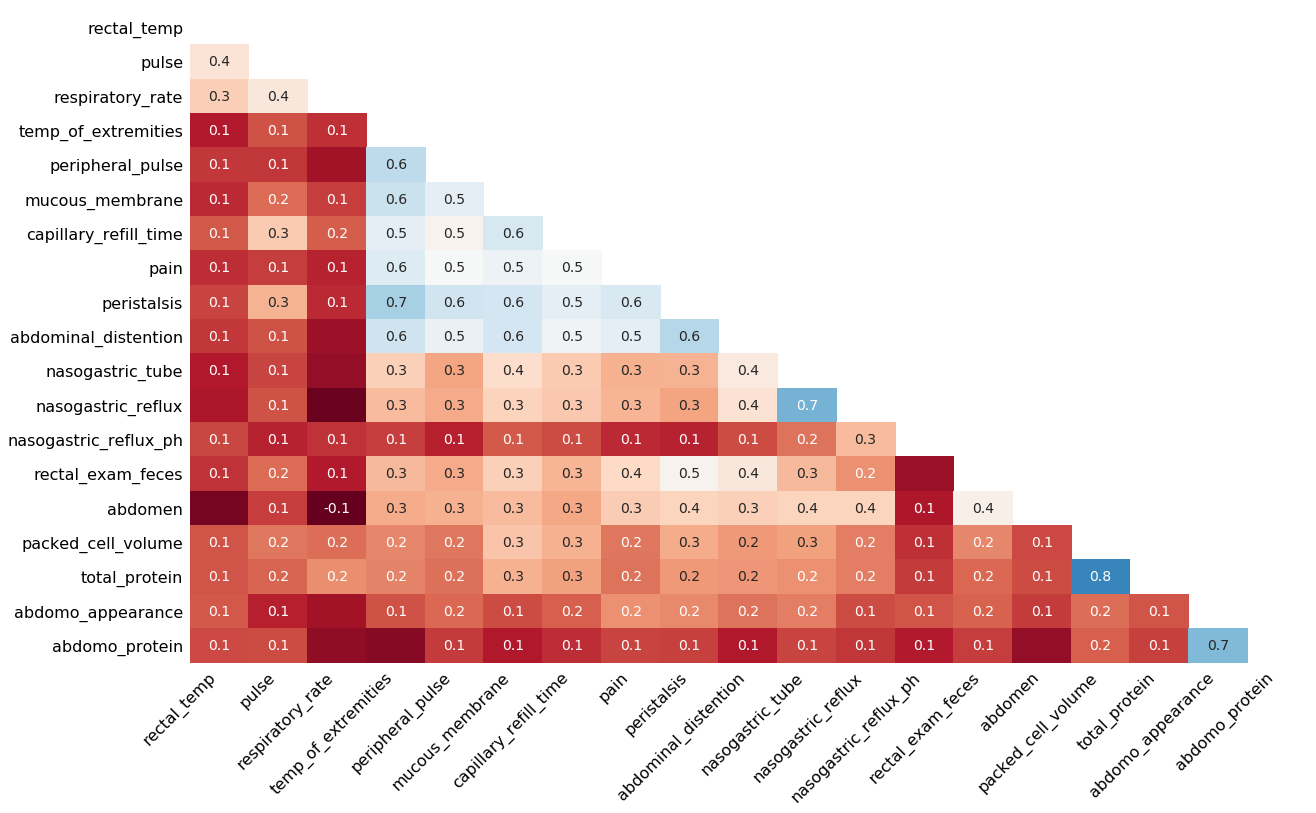

In [9]:
msno.heatmap(horse_df);

In [10]:
# Categorical variables in the form of strings or integers. 
horse_df.dtypes.value_counts()

object     17
float64     7
int64       4
dtype: int64

In [11]:
# Inspect categorical vs numerical
# Not all numerical variables are continuous, some are categories themselves. 
categorical=[]
numerical=[]
for col in horse_df.columns.values:
    if horse_df[col].dtype=='object':
        categorical.append(col)
    else:
        numerical.append(col)
print(len(categorical)," Categorical Columns are \n",categorical,'\n')
print(len(numerical),"Numerical columns are \n",numerical)

obj=horse_df[categorical]
nonobj=horse_df[numerical]

17  Categorical Columns are 
 ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'outcome', 'surgical_lesion', 'cp_data'] 

11 Numerical columns are 
 ['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


In [12]:
# Transform them using LabelEncoder without imputing
# When we encode categories numerically, we can assign 0 to missing data. 
from sklearn.preprocessing import LabelEncoder
clean_horse = horse_df.copy(deep=True)
le_dict = dict()

# Remove nan values in categories by using 0
for column in clean_horse.drop(nonobj, axis=1):
    clean_horse[column] = clean_horse[column].fillna(0)
    le = LabelEncoder().fit(clean_horse[column].astype(str))
    clean_horse[column] = le.transform(clean_horse[column].astype(str))
    le_dict[column] = le

In [13]:
horse_df.temp_of_extremities.unique()

array(['cool', nan, 'normal', 'cold', 'warm'], dtype=object)

In [14]:
horse_df['temp_of_extremities'].head(5)

0      cool
1       NaN
2    normal
3      cold
4       NaN
Name: temp_of_extremities, dtype: object

In [15]:
clean_horse['temp_of_extremities'].head(5)

0    2
1    0
2    3
3    1
4    0
Name: temp_of_extremities, dtype: int64

In [16]:
y = clean_horse['outcome']

### Why do we care?

1. **Increase of bias/Underfitting**: 
    In statistics, bias reflects the extent to which your expected values differ from the true population parameters that you are trying to estimate. Concretely, bias arises in a dataset with missing data whenever for a variable, the missing data differs substantially from the observed data.

    **Longitudinal study** and **dropout** : Let’s take a controlled drug study in medicine. In such a study, one compares the two arms of a study: the treatment arm and the control arm. Bias will depend on the relationship between missingness, treatment, and outcome. It is not uncommon for patients in the treatment arm to drop out due to adverse reactions to the treatment, or due to lack of improvement. In parallel, particularly healthy subjects, or ones who react exceptionally well to the treatment, will have very high completion rates for the study. The former, missing patients, will then become missing data in the final study. Ignoring them would lead to biased estimates of the efficacy of the treatment. We would be estimating how efficient the treatment was for a subsample of the population, the “healthier/better reacting” patients that completed the study, as opposed to the entire target population. 
    
    **Censoring**: Values for certain variables might be below certain thresholds making them innacurate

**2. Reduction of power:**
    In statistics, power, scaled from 0 to 1, is the probability that a hypothesis test correctly rejects the null hypothesis when it is false. This type of error is also called a type 2 error. The higher the power of your study is, the less likely you are to make a type 2 error.

Statistical power is influenced by two characteristics of your study: 
    1. Sample size 
    2. Variability of the outcomes observed. 
We therefore see that power increases if the sample size increases, or if the variability of the outcomes observed decreases. 

The mechanisms through which missing data directly influences the power of your study:
    * if you simply delete the observations with missing values, you reduce your effective sample size, and therefore reduce your power
    * if your missing values are more extreme figures than the observed ones (outliers), which regularly happens in practice, you will underestimate your variability and therefore artificially narrow your confidence interval (small variance, higher bias)


Inspect correlations in the dataset and correlation matrix in order to pick items for regression

Correlation of features (X) wrt. outcome (Y) in ascending order
outcome                  1.000000
packed_cell_volume       0.421703
pulse                    0.366235
surgical_lesion          0.332933
total_protein            0.263209
abdomo_protein           0.225812
peristalsis              0.201047
nasogastric_reflux_ph    0.196099
surgery                  0.189222
temp_of_extremities      0.185245
abdomen                  0.173353
rectal_exam_feces        0.165896
abdomo_appearance        0.163500
pain                     0.152912
capillary_refill_time    0.121691
hospital_number          0.106396
age                      0.101782
lesion_1                 0.100738
lesion_2                 0.098993
abdominal_distention     0.094556
respiratory_rate         0.089952
cp_data                  0.078066
nasogastric_reflux       0.056589
peripheral_pulse         0.049982
lesion_3                 0.044631
mucous_membrane          0.032255
rectal_temp              0.019362
nasogastric_tube  

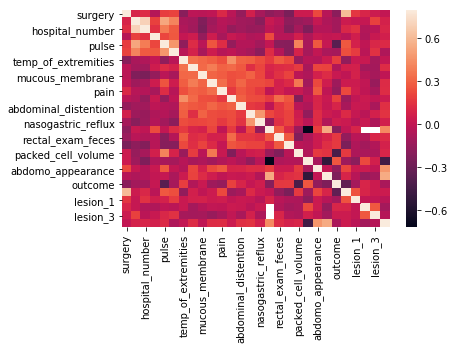

In [17]:
train_corr=clean_horse.corr()
sns.heatmap(train_corr, vmax=0.8)
corr_values=train_corr['outcome'].sort_values(ascending=False)
corr_values=abs(corr_values).sort_values(ascending=False)
print("Correlation of features (X) wrt. outcome (Y) in ascending order")
print(abs(corr_values).sort_values(ascending=False))

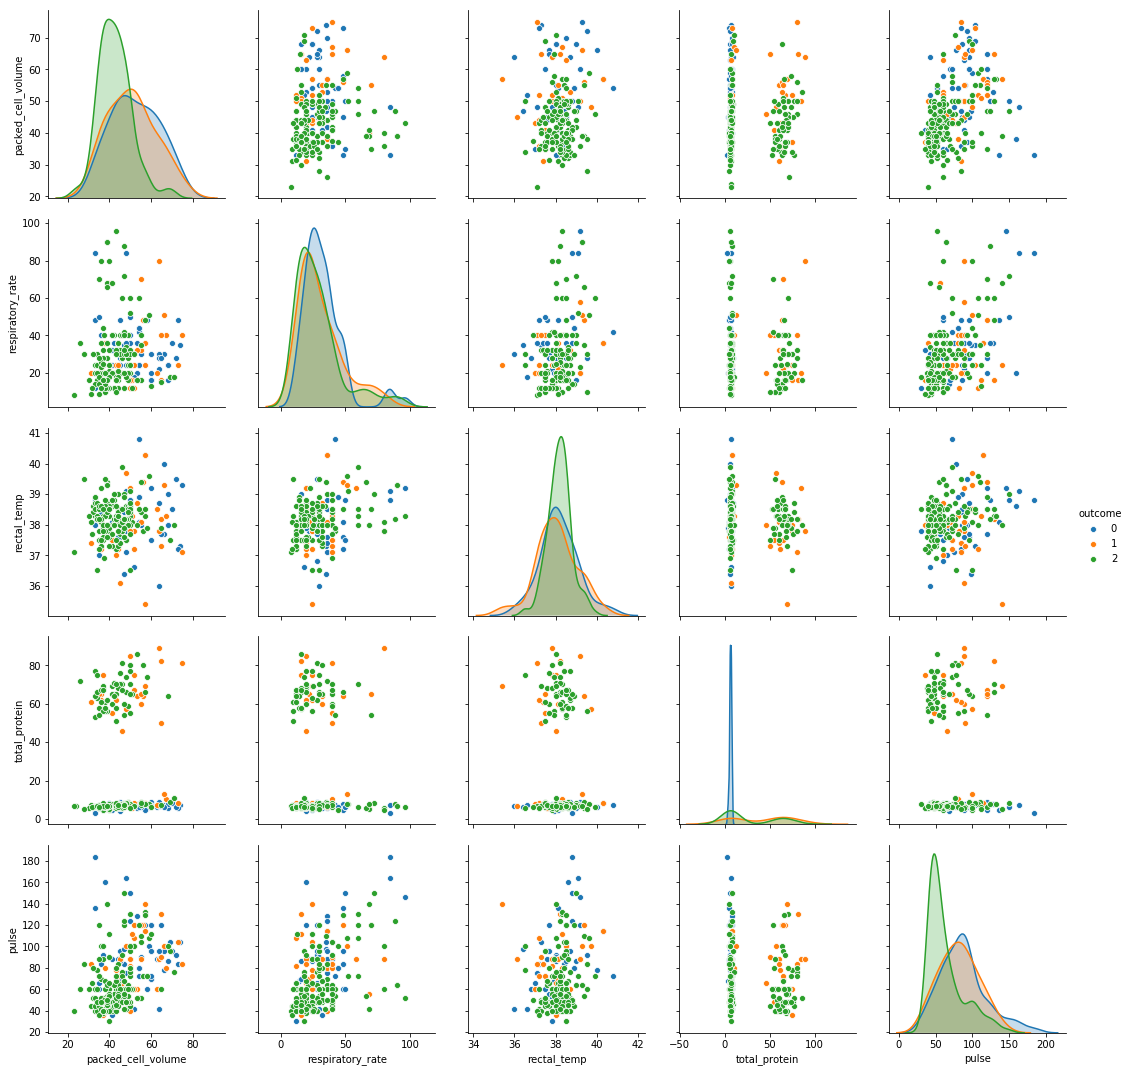

In [18]:
# Get a feel of the data and correlations lived = 2, died = 0 
# Can observe respiratory rates are slightly higher for the ones who died 
# Can observe the peak around 0 for total proteins for the horses who died
# plt.hist(clean_horse['abdomo_protein'].fillna(clean_horse['abdomo_protein'].mean()))
g = sns.pairplot(data=clean_horse, vars=['packed_cell_volume','respiratory_rate','rectal_temp','total_protein','pulse'], hue='outcome', height=3);

## Description and patterns of missing data

1. Unit vs. item nonresponse - 1930s polls, Brooklyn area. 
2. Univariate 
3. Monotone vs. non-monotone

![title](img/unit-nonresponse.png)
![title](img/item-nonresponse.png)
![title](img/univariate.png)
![title](img/monotone.png)
![title](img/non-monotone.png)

-------

## Mechanisms of missing data
It is hard to differentiate between the first one (MCAR) and the last one (MNAR) but we'll try to show you some tricks! 

**MCAR: Missing Completely at Random**

If the missingness of the data is *unrelated* to both the observed and the unobserved data, the missing data is said to be missing completely at random (MCAR). In this situation, the missing data is a random subsample of the complete dataset. Discarding missing data will not bias estimates or lose information

In this specific case, analyzing only the observations with complete data in the study (complete case analysis) would lead to a loss of power/efficiency in the study, but not to a higher bias in the estimates. As a rule of thumb, if less than 40% from a feature is missing, we shouldn't remove it.

An important caveat is that MCAR and correlations are not necessarily mutually exclusive, i.e. the possibility that the missingness of a variable X is related to the missingness of some other variable Y. If in a survey the same subjects refused to answer both the age and the gender questions, this can mean both MCAR or not. 

In [ ]:
# If data is MCAR then throwing out observations does not influence your bias. 
# Ok, let's do predictions using variables that appear to be MCAR and have missing data. Let's take abdomo_appearance

In [ ]:
# How many are missing values? (165)
plt.hist(clean_horse.abdomo_appearance);

In [ ]:
# 1. Do prediction with this to show bias doesn't change if removing variables? 
# 2. Would need to do analysis as well, the kind that tells you whether it is or isn't...
clean_horse.abdomo_appearance

**MAR: Missing at Random** 

If missingness of the data depends only on the observed data and not on the unobserved data, we say that the data is missing at random (MAR). This implies that after taking the observed data into account, there are no systematic differences between items (subjects) with missing data and those without missing data.

In [ ]:
# Add something interesting here

**MNAR: Missing not at Random**
This occurs when the missingness of the data depends on the values of the missing data themselves. It often occurs for the income variable in surveys for example: both high income earners and low income earners are less likely to report their income (to answer the income question) than are the average income earners. Therefore the fact that those answers will be missing will be correlated to the value of those missing data points themselves. The data in such a study cannot be said to be missing at random.


Most statistical tools require data to be MAR or MCAR. However, in the presence of MNAR, the same statistical tools remain the best thing we have – just much more uncertain/unreliable.


In [ ]:
# Add something interesting here

# Add something related to how things correlate and how they are most likely not missing at random. 
# And how in some cases you can't tell

## What is imputation? 

What is imputation?

Definition: Imputation amounts to filling in missing values with appropriate estimates for them, and then using standard complete data methods to study the now complete dataset. “From an operational standpoint, imputation solves the missing-data problem at the outset, enabling the analyst to proceed without further hindrance.” (Schafer, 1999)

Objective: It is important to understand from the beginning the objective of imputation. It is not to estimate as accurately as possible any single missing value. The objective is to create a complete dataset that preserves as much as possible the characteristics of the original complete dataset. Intuitively this makes sense because in applied statistics, we aim to infer parameters about a population, based on the estimates computed from our sample. As such we are interested in statistics about aggregates, rather than in the exact value of single observations. As Little and Rubin (2002) state “It is important to note at the outset that usually sample surveys are conducted with the goal of making inferences about population quantities such as means, correlations and regression coefficients, and the values of individual cases in the data set are not the main interest. Thus, the objective of imputation is not to get the best possible predictions of the missing values, but to replace them by plausible values in order to exploit the information in the recorded variables in the incomplete cases for inference about population parameters.” 
Cautionary note: many methods to impute missing data. You need to be careful to both use one of the statistically robust methods, and to use a software package that implements it correctly. The theory is very esoteric and there are many permutations possible in implementing it.

### Single imputation
As seen above, in this technique, missing values are replaced with a single value derived from the non-missing values for each variable, for example the mean or mode of that variable in your dataset.

Most recommended method of imputation, especially in data analysis world. Only method provided by frameworks such as pandas.

As ACA and CCA, it produces unbiased estimates under MCAR.

What is the problem with single imputation?

You are obviously not changing the mean nor mode of your variables since you are using it to fill in the missing values.

Variances and covariances will be severely underestimated (Haitovsky, 1968), for two reasons. First, filling in all missing values with the mean will not account for the variation that would most likely be present in reality between those observed values. You are imputing the mean for every missing value, while the real values would probably vary around the mean value. Second, your ultimately increased sample size will result in smaller standard errors, and these will not accurately reflect the uncertainty actually existing in your dataset due to those missing values. In studying single imputation methods, Pigott (2001) concludes that “under no circumstances does mean imputation produce unbiased results…Bias in the estimation of variances and standard errors are compounded when estimating multivariate parameters such as regression coefficients.”

What about longitudinal studies and the common practice of LOCF and BOCF?

They are simply specific cases of single imputation. As such, they do not take into account the information about the missing data contained in the observed data, they lead to biased estimates, and they underestimate the uncertainty contained in the dataset.

In [19]:
print("Number of missing values for nasogastric_reflux_ph: %d" %clean_horse.nasogastric_reflux_ph.isnull().sum())
print("Number of missing values for nasogastric_reflux_: %d" %(clean_horse.nasogastric_reflux==0).sum())

Number of missing values for nasogastric_reflux_ph: 246
Number of missing values for nasogastric_reflux_: 106


In [20]:
clean_horse_1 = clean_horse.copy(deep=True)
clean_horse_1 = clean_horse_1[['nasogastric_reflux_ph','nasogastric_reflux','outcome']]
clean_horse_1 = clean_horse_1.dropna()

In [21]:
clean_horse_1.shape

(53, 3)

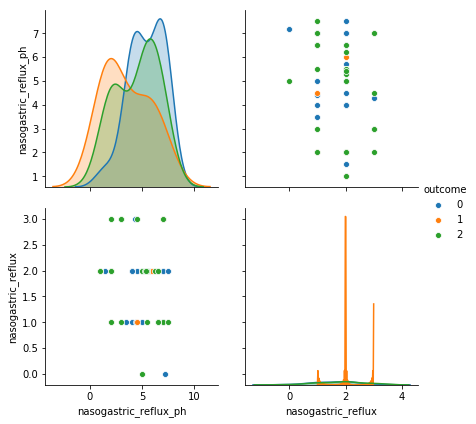

In [22]:
g = sns.pairplot(data = clean_horse_1, vars=['nasogastric_reflux_ph','nasogastric_reflux'],hue='outcome',height=3)

Before single imputation, the nasogastric reflux ph is higher for the dead animals. However, once single imputation has been performed with the mean, we observe a complete overlap between dead and alive (Blue/green)

In [23]:
clean_horse_1.nasogastric_reflux_ph.mean()

4.7075471698113205

In [24]:
clean_horse_1.nasogastric_reflux_ph.mode()

0    2.0
dtype: float64

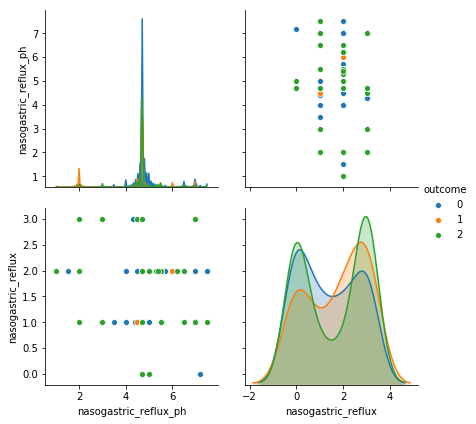

In [25]:
clean_horse_simp = clean_horse.copy(deep=True)

clean_horse_simp.nasogastric_reflux_ph.fillna(clean_horse_simp.nasogastric_reflux_ph.mean(),inplace=True) 
clean_horse_simp.nasogastric_reflux.fillna(clean_horse_simp.nasogastric_reflux.mode(),inplace=True)
g = sns.pairplot(data = clean_horse_simp, vars=['nasogastric_reflux_ph','nasogastric_reflux'],hue='outcome',height=3)

Let's try imputing with the **median**! They are even more confounded. This is also because of the huge number of missing values. 

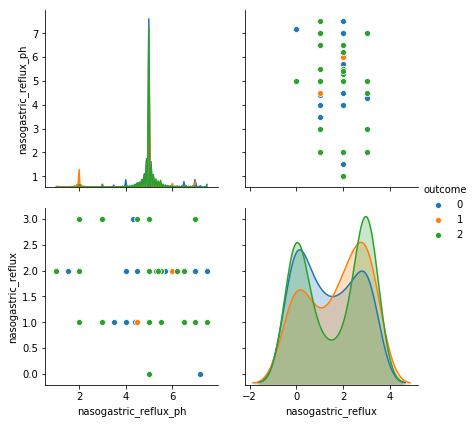

In [26]:
clean_horse_simp = clean_horse.copy(deep=True)

clean_horse_simp.nasogastric_reflux_ph.fillna(clean_horse_simp.nasogastric_reflux_ph.median(),inplace=True) 
clean_horse_simp.nasogastric_reflux.fillna(clean_horse_simp.nasogastric_reflux.mode(),inplace=True)
g = sns.pairplot(data = clean_horse_simp, vars=['nasogastric_reflux_ph','nasogastric_reflux'],hue='outcome',height=3)

Imputing with the mode of the data, we observe the distributios are somewhat preserved

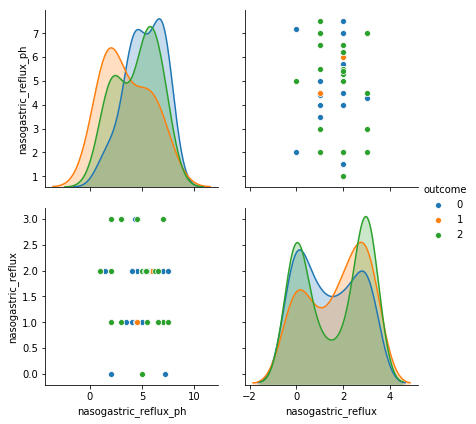

In [27]:
clean_horse_simp = clean_horse.copy(deep=True)
clean_horse_simp.nasogastric_reflux_ph.fillna(clean_horse_simp.nasogastric_reflux_ph.mode(),inplace=True) 
clean_horse_simp.nasogastric_reflux.fillna(clean_horse_simp.nasogastric_reflux.mode(),inplace=True)
g = sns.pairplot(data = clean_horse_simp, vars=['nasogastric_reflux_ph','nasogastric_reflux'],hue='outcome',height=3)

###  Linear estimator analysis
The bias for the linear estimator will increase if the missing data is actually not around the mean. 
To demonstrate this we will compare the Bias by imputing with the mean and median. 

The more different the actual missing data is from the mean, the bigger the bias. 
For illustration purposes, we will implement a regression model dependent on two variables: 
**packed_cell_volume** and **pulse**


In [28]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()
X = clean_horse[['packed_cell_volume','pulse','outcome']]

**1. Complete-case analysis: Remove missing values** 

If the data is missing completely at random complete case analysis can be considered (Nakai & Weiming, 2011; Allison, 2001). In this case your reduced dataset will be a random subsample of the full dataset – the parameter estimates therefore will be as unbiased for the reduced dataset as they would have been for the full dataset.
Allison (2001) finds that it is more robust than all other basic methods, such as available case analysis.

Unfortunately, complete case analysis has been shown to produce biased estimates if the data is not missing completely at random (Bell et al, 2013), in addition to the loss of information and power that result from all the observations hence deleted.



In [29]:
X_non_imputed = X.dropna()
y_non_imputed = X_non_imputed.outcome
X_non_imputed = X_non_imputed.drop('outcome',axis=1)
# Train the model using the training sets
regr.fit(X_non_imputed, y_non_imputed)

# Make predictions using the testing set
y_pred = regr.predict(X_non_imputed)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_non_imputed, y_pred))
# Explained variance score: 1 is perfect p|rediction
print('Variance score: %.2f' % r2_score(y_non_imputed, y_pred))
val1 = mean_squared_error(y_non_imputed, y_pred) - np.var(y_pred)
print('Bias squared: %.2f' % val1)
r1 = regr.coef_
var1 = np.var(y_pred)


Coefficients: 
 [-0.02519242 -0.00776114]
Mean squared error: 0.55
Variance score: 0.23
Bias squared: 0.39


**2. Available-case analysis: Impute both features using their mean** 

Handling missing data. It amounts to taking your incomplete dataset with missing values, and for the variable of interest, using all the observations that do not have missing values for that variable.
In practice this means that in the same study you will use different subsamples from your dataset for different variables of interest.

How is this possible? In linear regression we know that a regression can be estimated using only either the sample means and covariance matrix, or the means, standard deviations and correlation matrix (see any introductory statistical book such as Introduction to Statistical Learning). Pairwise deletion aims to take advantage of this insight, computing these statistics using all the cases for which data is available, across our dataset.

In [30]:
X_imputed = clean_horse[['packed_cell_volume','pulse']]
X_imputed['packed_cell_volume'] = X_imputed['packed_cell_volume'].fillna(X_imputed['packed_cell_volume'].mean())
X_imputed['pulse'] = X_imputed['pulse'].fillna(X_imputed['pulse'].mean())
y_imputed = y 
# Train the model using the training sets
regr.fit(X_imputed, y_imputed)

# Make predictions using the testing set
y_pred = regr.predict(X_imputed)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_imputed, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance explained: %.2f' % r2_score(y_imputed, y_pred))
val2 = mean_squared_error(y_imputed, y_pred) - np.var(y_pred)
print('Bias squared: %.2f' % val2)

Coefficients: 
 [-0.02752577 -0.00712789]
Mean squared error: 0.59
Variance explained: 0.21
Bias squared: 0.44


**3. Impute using "outliers"** 

In [31]:
X_imputed = clean_horse[['packed_cell_volume','pulse']]
X_imputed['packed_cell_volume'] = X_imputed['packed_cell_volume'].fillna(X_imputed['packed_cell_volume'].median()-20)
X_imputed['pulse'] = X_imputed['pulse'].fillna(X_imputed['pulse'].median()-20)
y_imputed = y 
# Train the model using the training sets
regr.fit(X_imputed, y_imputed)

# Make predictions using the testing set
y_pred = regr.predict(X_imputed)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_imputed, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_imputed, y_pred))
val3 = mean_squared_error(y_imputed, y_pred) - np.var(y_pred)
print('Bias squared: %.2f' % val3)

Coefficients: 
 [-0.01668538 -0.00690275]
Mean squared error: 0.64
Variance score: 0.14
Bias squared: 0.53


**4. Imputing with predictions**   
i.e. Classifying outcome with for example logistic regression



In [32]:
# Use only 2 variables and "predict" 20% of the outcomes. 
# For illustration purposes
X_imputed = clean_horse[['packed_cell_volume','pulse','outcome']]
X_imputed['packed_cell_volume'] = X_imputed['packed_cell_volume'].fillna(X_imputed['packed_cell_volume'].mean())
X_imputed['pulse'] = X_imputed['pulse'].fillna(X_imputed['pulse'].median())


In [33]:
msk = np.random.rand(len(X_imputed)) < 0.8

data_train = X_imputed[msk]
data_test = X_imputed[~msk]

In [34]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
X_train = data_train[['packed_cell_volume','pulse']]
Y_train = data_train[['outcome']]

X_test = data_test[['packed_cell_volume','pulse']]
Y_test = data_test[['outcome']]
lr_model.fit(X_train,Y_train.values.ravel())

predictions = lr_model.predict(X_test)

In [35]:
#Inspect predictions vs. original data
predictions - Y_test.values.T

array([[ 2,  0,  2,  0,  0,  0, -1, -1, -2,  0,  0,  2,  2,  0, -1,  0,
         0,  1,  0,  2,  0,  0,  0,  1,  0,  1,  0,  2,  2,  0,  0,  0,
         0, -2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,
         1,  0,  0, -1,  0, -2,  0,  0,  2,  0,  0,  0,  0,  1,  1,  2,
         0,  0,  1,  0,  1]])

In [36]:
lr_model.score(X_test,Y_test)

0.6376811594202898

**5. Most statistical tools, theoretical and applied are designed for complete datasets**

Almost all standard statistical analysis techniques and their implementations in various softwares were developed for complete datasets, and cannot handle appropriately incomplete ones (Schafer and Graham, 2002).

(C/R) - Classification/Regression


Models| Handle Missing data| Reasoning
---|---|---
Linear Models (C/R) |No| Discriminative model, modelling of output rather than input
Non-linear models: Neural Networks (C/R) |No| Same as above
Decision Trees (C/R) |Yes| Defaults missing data to a node
Random Forest (C/R) |Sometimes|Computationally intensive for growing trees. It also depends on the underlying algorithm, i.e. CART 
Bayesian Models & Generative Models |Yes| They can handle missing data probabilistically since you're modelling the input distribution

_____

### Avanced example: Rubin's Pooling rules for 10 different dataset imputations.

After multiple imputation, we have 10 datasets that we want to average to find the best imputation together with the associated variance.

In [37]:
# Keep track of all estimates for the artificial 10 datasets we built
# More runs would give better estimates
data_estimates = np.zeros((10,2))
data_estimates_covar = np.zeros((10,2,2))

In [38]:
for i in range(0,10): 
    X_imputed = clean_horse[['packed_cell_volume','pulse']]    
    
    # Fill missing values with random numbers but make sure they are positive.
    # We make the assumption of independence between the two variables. 
    imputation_volume = np.abs(X_imputed['packed_cell_volume'].mean() - np.random.randint(0,30))
    X_imputed['packed_cell_volume'] = X_imputed['packed_cell_volume'].fillna(imputation_volume)
    
    imputation_pulse = np.abs(X_imputed['pulse'].median()-np.random.randint(0,30))
    X_imputed['pulse'] = X_imputed['pulse'].fillna(imputation_pulse)
    
    # The estimates 
    # Means of each variable
    data_estimates[i,:] = [X_imputed.packed_cell_volume.mean(),X_imputed.pulse.mean()]
    # Covariance of 2D dataset
    # Covariance structure - (var(x,x), var(x,y), var(y,x),var(y,y))
    data_estimates_covar[i,:] = np.cov(X_imputed.T)
    

# Inspect one mean and covariance Q_l and U_l
print("Means: \n",data_estimates[1])
print("\nCovariance:\n",data_estimates_covar[1])

Means: 
 [46.11342747 69.75250836]

Covariance:
 [[ 98.6769609  102.35537262]
 [102.35537262 812.58954906]]


Now onto Rubin's rules
Datasets: $m = 10$  
1. Overall mean for data estimates: $\hat{Q} = \sum_{l=1}^{m}\hat{Q_l}$  
2. Variance-Covariance for data estimates based on covariance of each estimate: $\hat{U} = \sum_{l=1}^{m}\hat{U_l}$

3. Variance in the estimates: $B = \frac{1}{m-1} \sum_{l=1}^{m}(\hat{Q_l}-\hat{Q})^T * (\hat{Q_l}-\hat{Q})$
4. Total variance for real $Q$: $Q-\hat{Q}: T = \hat{U} + B + \frac{B}{m} $  
5. Relative increase in variance due to nonresponse: $r = (1 + \frac{1}{m})*\frac{B}{\hat{U}}$


In [39]:
#1. Overall means 
Q_hat = data_estimates.mean(axis=0)
print("Overall Means:",Q_hat)

Overall Means: [45.27931376 70.26622074]


In [40]:
#2. Covariance
U_hat = data_estimates_covar.mean(axis=0)
print("Overall mean covariance in datasets\n",U_hat)

Overall mean covariance in datasets
 [[113.35238906 105.49591681]
 [105.49591681 790.13079392]]


In [41]:
#3. Variance in estimates - take 1
diff = Q_hat-data_estimates
B1 = 1/9 * np.dot(diff.T,diff)
print("Take 1: Covariance within the estimates\n",B1)

Take 1: Covariance within the estimates
 [[ 0.6129218  -0.05588006]
 [-0.05588006  0.10194069]]


In [42]:
# Check yourself before you wreck yourself
#3. Variance in estimates - take 2 
B2 = np.cov(data_estimates.T) 
print("Take 1: Covariance within the estimates\n",B2)

Take 1: Covariance within the estimates
 [[ 0.6129218  -0.05588006]
 [-0.05588006  0.10194069]]


In [43]:
#4. Total variance
T = U_hat + (1+1/10)*B1
print("Total Variance\n",T)

Total Variance
 [[114.02660305 105.43444874]
 [105.43444874 790.24292869]]


In [44]:
#5. Relative increase in variance due to nonresponse
r = (1 + 1/10)*B1/U_hat
print("Relative increase in variance due to non-response\n",r)

Relative increase in variance due to non-response
 [[ 0.00594795 -0.00058266]
 [-0.00058266  0.00014192]]


In [45]:
# Let's compare to the complete-data mean and covariance
means_complete = X_non_imputed.mean(axis=0) 
cov_complete = np.cov(X_non_imputed.T)

# We observe they are quite close! 
print("Difference between complete data and imputed data means:\n", means_complete - Q_hat)
print("\nDiference between complete data and imputed data covariance:\n", cov_complete-T)

Difference between complete data and imputed data means:
 packed_cell_volume    1.052702
pulse                 1.824688
dtype: float64

Diference between complete data and imputed data covariance:
 [[-9.24243372 13.69001014]
 [13.69001014 32.72099628]]
